In [50]:
import keras
keras.__version__

'2.2.0'

In [51]:
import csv
import numpy as np
from sklearn.preprocessing import LabelBinarizer

csvFile = '/Users/aleksey/Main/MachineLearning/moving-classification/gyroscope_data.csv'
numberOfMeasurementsPerSample = 50


csvFileReader = csv.reader(open(csvFile), delimiter=',')
linesWithoutHeader = ([x for x in csvFileReader])[1:]

def removeLastColumn(lines):
    return [line[:-1] for line in lines]

def prepareDictionaryWithLabelsToSortedMeasurements(lines):
    def filterLinesWithLabel(label, lines):
        return [line for line in lines if line[-1] == label]

    def sortByTime(lines):
        return sorted(lines, key=lambda line: line[-2], reverse=False)
    
    def findUniqLabes(lines):
        return set([line[-1] for line in lines])
    
    labesToFeatures = {}
    
    for label in findUniqLabes(lines):
        labesToFeatures[label] = removeLastColumn(filterLinesWithLabel(label, lines))
    
    return labesToFeatures

labelsToMeasurements = prepareDictionaryWithLabelsToSortedMeasurements(linesWithoutHeader)                                                   

def prepareData(labelsToMeasurements, numberOfMeasurementsPerSample):
    def createSamplesForLabel(label, measurements, numberOfMeasurementsPerSample):
        numberOfSamples = len(measurements) // numberOfMeasurementsPerSample
        
        samples = np.zeros((numberOfSamples, numberOfMeasurementsPerSample, len(measurements[0])))
        
        for i in range(0, numberOfSamples):
            measurementsPerSample = measurements[i * numberOfMeasurementsPerSample : (i + 1) * numberOfMeasurementsPerSample]
            samples[i] = np.array(measurementsPerSample)
        return samples
    
    samples = []
    targets = []
    
    for label, measurements in labelsToMeasurements.items():
        samplesOfLabel = createSamplesForLabel(label, measurements, numberOfMeasurementsPerSample)
        
        samples.extend(samplesOfLabel)
        targets.extend(np.full((samplesOfLabel.shape[0]), label))
    
    return np.array(samples), np.array(targets)

def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

samples, targets = prepareData(labelsToMeasurements, numberOfMeasurementsPerSample)
samples, targets = shuffleSamplesAndTargets(samples, targets)
targets = LabelBinarizer().fit_transform(targets)

print(samples.shape)
print(targets.shape)

(1260, 50, 6)
(1260, 3)


In [52]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

train_part_end = int(train_part_in_percents * samples.shape[0])
val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

train_data = samples[0:train_part_end]
train_labels = targets[0:train_part_end]
print(train_data.shape)
print(train_labels.shape)

val_data = samples[train_part_end:val_part_end]
val_labels = targets[train_part_end:val_part_end]
print(val_data.shape)
print(val_labels.shape)

test_data = samples[val_part_end:test_part_end]
test_labels = targets[val_part_end:test_part_end]
print(test_data.shape)
print(test_labels.shape)

(756, 50, 6)
(756, 3)
(252, 50, 6)
(252, 3)
(252, 50, 6)
(252, 3)


In [77]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GRU(32, dropout=0.5, recurrent_dropout=1))
model.add(layers.Dense(3, activation='softmax'))

In [78]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.0005),
              loss='mse',
              metrics=['accuracy'])

In [79]:
history = model.fit(train_data,
                    train_labels,
                    epochs=300,
                    batch_size=64,
                    validation_data=(val_data, val_labels))

Train on 756 samples, validate on 252 samples
Epoch 1/300
756/756 [==============================] - 3s 3ms/step - loss: 0.2645 - acc: 0.3492 - val_loss: 0.2169 - val_acc: 0.4206
Epoch 2/300
756/756 [==============================] - 0s 440us/step - loss: 0.2441 - acc: 0.3955 - val_loss: 0.2011 - val_acc: 0.4762
Epoch 3/300
756/756 [==============================] - 0s 399us/step - loss: 0.2308 - acc: 0.4418 - val_loss: 0.1833 - val_acc: 0.5913
Epoch 4/300
756/756 [==============================] - 0s 433us/step - loss: 0.2292 - acc: 0.4418 - val_loss: 0.1701 - val_acc: 0.6310
Epoch 5/300
756/756 [==============================] - 0s 433us/step - loss: 0.2093 - acc: 0.4709 - val_loss: 0.1563 - val_acc: 0.6706
Epoch 6/300
756/756 [==============================] - 0s 387us/step - loss: 0.2107 - acc: 0.5093 - val_loss: 0.1489 - val_acc: 0.7103
Epoch 7/300
756/756 [==============================] - 0s 386us/step - loss: 0.1982 - acc: 0.5238 - val_loss: 0.1471 - val_acc: 0.7103
Epoch 8/300

Epoch 61/300
756/756 [==============================] - 0s 403us/step - loss: 0.0996 - acc: 0.7897 - val_loss: 0.0752 - val_acc: 0.8571
Epoch 62/300
756/756 [==============================] - 0s 388us/step - loss: 0.1013 - acc: 0.7685 - val_loss: 0.0765 - val_acc: 0.8333
Epoch 63/300
756/756 [==============================] - 0s 387us/step - loss: 0.1024 - acc: 0.7725 - val_loss: 0.0762 - val_acc: 0.8333
Epoch 64/300
756/756 [==============================] - 0s 384us/step - loss: 0.0975 - acc: 0.8003 - val_loss: 0.0766 - val_acc: 0.8333
Epoch 65/300
756/756 [==============================] - 0s 383us/step - loss: 0.1001 - acc: 0.7857 - val_loss: 0.0767 - val_acc: 0.8254
Epoch 66/300
756/756 [==============================] - 0s 380us/step - loss: 0.0981 - acc: 0.7897 - val_loss: 0.0756 - val_acc: 0.8373
Epoch 67/300
756/756 [==============================] - 0s 386us/step - loss: 0.0939 - acc: 0.7989 - val_loss: 0.0721 - val_acc: 0.8413
Epoch 68/300
756/756 [==========================

756/756 [==============================] - 0s 469us/step - loss: 0.0411 - acc: 0.9206 - val_loss: 0.0562 - val_acc: 0.8810
Epoch 122/300
756/756 [==============================] - 0s 476us/step - loss: 0.0463 - acc: 0.9220 - val_loss: 0.0521 - val_acc: 0.8770
Epoch 123/300
756/756 [==============================] - 0s 415us/step - loss: 0.0483 - acc: 0.9048 - val_loss: 0.0486 - val_acc: 0.8849
Epoch 124/300
756/756 [==============================] - 0s 443us/step - loss: 0.0451 - acc: 0.9153 - val_loss: 0.0503 - val_acc: 0.8770
Epoch 125/300
756/756 [==============================] - 0s 419us/step - loss: 0.0452 - acc: 0.9087 - val_loss: 0.0504 - val_acc: 0.8730
Epoch 126/300
756/756 [==============================] - 0s 501us/step - loss: 0.0401 - acc: 0.9206 - val_loss: 0.0474 - val_acc: 0.8770
Epoch 127/300
756/756 [==============================] - 0s 395us/step - loss: 0.0452 - acc: 0.9167 - val_loss: 0.0472 - val_acc: 0.8889
Epoch 128/300
756/756 [==============================] 

Epoch 181/300
756/756 [==============================] - 0s 498us/step - loss: 0.0202 - acc: 0.9630 - val_loss: 0.0294 - val_acc: 0.9563
Epoch 182/300
756/756 [==============================] - 0s 516us/step - loss: 0.0147 - acc: 0.9762 - val_loss: 0.0230 - val_acc: 0.9603
Epoch 183/300
756/756 [==============================] - 0s 497us/step - loss: 0.0140 - acc: 0.9709 - val_loss: 0.0271 - val_acc: 0.9524
Epoch 184/300
756/756 [==============================] - 0s 520us/step - loss: 0.0157 - acc: 0.9656 - val_loss: 0.0231 - val_acc: 0.9643
Epoch 185/300
756/756 [==============================] - 0s 494us/step - loss: 0.0111 - acc: 0.9815 - val_loss: 0.0218 - val_acc: 0.9643
Epoch 186/300
756/756 [==============================] - 0s 464us/step - loss: 0.0148 - acc: 0.9722 - val_loss: 0.0208 - val_acc: 0.9643
Epoch 187/300
756/756 [==============================] - 0s 480us/step - loss: 0.0136 - acc: 0.9762 - val_loss: 0.0213 - val_acc: 0.9683
Epoch 188/300
756/756 [==================

Epoch 241/300
756/756 [==============================] - 0s 507us/step - loss: 0.0076 - acc: 0.9841 - val_loss: 0.0140 - val_acc: 0.9762
Epoch 242/300
756/756 [==============================] - 0s 491us/step - loss: 0.0076 - acc: 0.9907 - val_loss: 0.0182 - val_acc: 0.9683
Epoch 243/300
756/756 [==============================] - 0s 509us/step - loss: 0.0048 - acc: 0.9921 - val_loss: 0.0171 - val_acc: 0.9722
Epoch 244/300
756/756 [==============================] - 0s 481us/step - loss: 0.0082 - acc: 0.9854 - val_loss: 0.0131 - val_acc: 0.9802
Epoch 245/300
756/756 [==============================] - 0s 506us/step - loss: 0.0081 - acc: 0.9854 - val_loss: 0.0120 - val_acc: 0.9802
Epoch 246/300
756/756 [==============================] - 0s 525us/step - loss: 0.0067 - acc: 0.9881 - val_loss: 0.0125 - val_acc: 0.9802
Epoch 247/300
756/756 [==============================] - 0s 465us/step - loss: 0.0078 - acc: 0.9868 - val_loss: 0.0145 - val_acc: 0.9762
Epoch 248/300
756/756 [==================

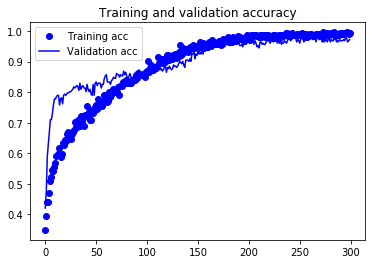

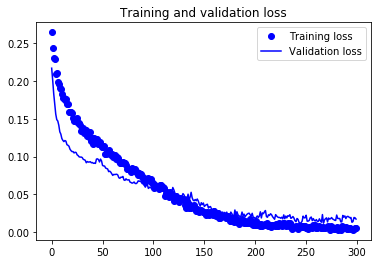

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [81]:
model.evaluate(test_data, test_labels)

252/252 [==============================] - 0s 129us/step


[0.00798562367535418, 0.9880952380952381]

In [58]:
model.predict(test_data[0:1])

array([[0.23351125, 0.02514297, 0.7413458 ]], dtype=float32)